#### Analyzed Uber trip data to uncover patterns in ride usage, peak times, and fare trends, providing insights for optimizing operations and improving user experience.

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

Loaded the Uber dataset using Pandas and displayed the first few rows for an initial overview of the data structure and content.

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   object 
 4   STOP        1155 non-null   object 
 5   MILES       1156 non-null   float64
 6   PURPOSE     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


In [13]:
# Filling NULL values in feature PURPOSE
df['PURPOSE'] = df['PURPOSE'].fillna("UNKNOWN")

# Filling NULL values in other important columns
df['END_DATE'] = df['END_DATE'].fillna(pd.Timestamp.now())  # Example: filling with the current timestamp
df['CATEGORY'] = df['CATEGORY'].fillna("UNKNOWN")
df['START'] = df['START'].fillna("UNKNOWN")
df['STOP'] = df['STOP'].fillna("UNKNOWN")

# Check for remaining NULL values
remaining_nulls = df.isnull().sum()
print(remaining_nulls)

# Proceed with analysis or further cleaning based on remaining nulls


START_DATE    735
END_DATE        0
CATEGORY        0
START           0
STOP            0
MILES           0
PURPOSE         0
dtype: int64


In [20]:
import pandas as pd

# Define a function to check if a date string is valid
def is_valid_date(date_str):
    if isinstance(date_str, str):
        return (pd.to_datetime(date_str.strip(), format='%d-%m-%Y %H:%M', errors='coerce') is not pd.NaT) or \
               (pd.to_datetime(date_str.strip(), format='%m/%d/%Y %H:%M', errors='coerce') is not pd.NaT)
    return False

# Filter out rows where START_DATE or END_DATE are not valid date strings
df = df[df['START_DATE'].apply(is_valid_date)]
df = df[df['END_DATE'].apply(is_valid_date)]

# Attempt to convert START_DATE and END_DATE into datetime format
def convert_dates(date_str):
    if isinstance(date_str, str):
        try:
            return pd.to_datetime(date_str.strip(), format='%d-%m-%Y %H:%M', errors='raise')
        except ValueError:
            return pd.to_datetime(date_str.strip(), format='%m/%d/%Y %H:%M', errors='raise')
    return pd.NaT

# Apply conversion
df['START_DATE'] = df['START_DATE'].apply(convert_dates)
df['END_DATE'] = df['END_DATE'].apply(convert_dates)

# Print rows that failed to convert, if any
invalid_dates = df[df['START_DATE'].isnull() | df['END_DATE'].isnull()]
if not invalid_dates.empty:
    print("Rows with invalid dates:")
    print(invalid_dates)

# Continue with the rest of the feature creation only if dates are valid
if invalid_dates.empty:
    df['TIME_DAY'] = df['START_DATE'].dt.hour
    df['TIME_OF_DAY'] = pd.cut(x=df['TIME_DAY'], bins=[0, 6, 11, 17, 21, 24],
                                labels=['Night', 'Morning', 'Afternoon', 'Evening', 'Night'], 
                                ordered=False)

    df['MONTH_OF_THE_RIDE'] = df['START_DATE'].dt.month.map({
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'April', 5: 'May', 6: 'June', 
        7: 'July', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    })

    df['DAY_OF_THE_RIDE'] = df['START_DATE'].dt.weekday.map({
        0: 'Mon', 1: 'Tues', 2: 'Wed', 3: 'Thus', 4: 'Fri', 5: 'Sat', 6: 'Sun'
    })

    df['DURATION_OF_THE_RIDE'] = (df['END_DATE'] - df['START_DATE']).dt.total_seconds() / 60

# Display the DataFrame
print(df.head())


           START_DATE            END_DATE  CATEGORY        START  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business  Fort Pierce   
1 2016-02-01 01:25:00 2016-02-01 01:37:00  Business  Fort Pierce   
2 2016-02-01 20:25:00 2016-02-01 20:38:00  Business  Fort Pierce   
3 2016-05-01 17:31:00 2016-05-01 17:45:00  Business  Fort Pierce   
4 2016-06-01 14:42:00 2016-06-01 15:49:00  Business  Fort Pierce   

              STOP  MILES          PURPOSE  TIME_DAY TIME_OF_DAY  \
0      Fort Pierce    5.1   Meal/Entertain        21     Evening   
1      Fort Pierce    5.0              NaN         1       Night   
2      Fort Pierce    4.8  Errand/Supplies        20     Evening   
3      Fort Pierce    4.7          Meeting        17   Afternoon   
4  West Palm Beach   63.7   Customer Visit        14   Afternoon   

  MONTH_OF_THE_RIDE DAY_OF_THE_RIDE  DURATION_OF_THE_RIDE  
0               Jan             Fri                   6.0  
1               Feb             Mon                  12.0  
2 

In [22]:
# Describe the DataFrame excluding START_DATE and END_DATE
df_description = df.drop(columns=['START_DATE', 'END_DATE']).describe()

print(df_description)


             MILES     TIME_DAY  DURATION_OF_THE_RIDE
count  1155.000000  1155.000000           1155.000000
mean     10.566840    14.696104            131.710823
std      21.579106     4.575226           7195.011535
min       0.500000     0.000000        -213096.000000
25%       2.900000    12.000000             10.000000
50%       6.000000    15.000000             17.000000
75%      10.400000    18.000000             28.000000
max     310.300000    23.000000          43223.000000


In [23]:
print('Min Timestamp in START_TIME is - {}'.format(df['START_DATE'].min()))
print('Max Timestamp in START_TIME is - {}'.format(df['START_DATE'].max()))

Min Timestamp in START_TIME is - 2016-01-01 21:11:00
Max Timestamp in START_TIME is - 2016-12-31 22:08:00


In [24]:
print("Total number of unique categories in CATEGORY - {}".format(df['CATEGORY'].nunique()))
print("Total number of unique categories in PURPOSE - {}".format(df['PURPOSE'].nunique()))
print("Total number of unique location in START - {}".format(df['START'].nunique()))
print("Total number of unique location in STOP - {}".format(df['STOP'].nunique()))

Total number of unique categories in CATEGORY - 2
Total number of unique categories in PURPOSE - 10
Total number of unique location in START - 177
Total number of unique location in STOP - 188


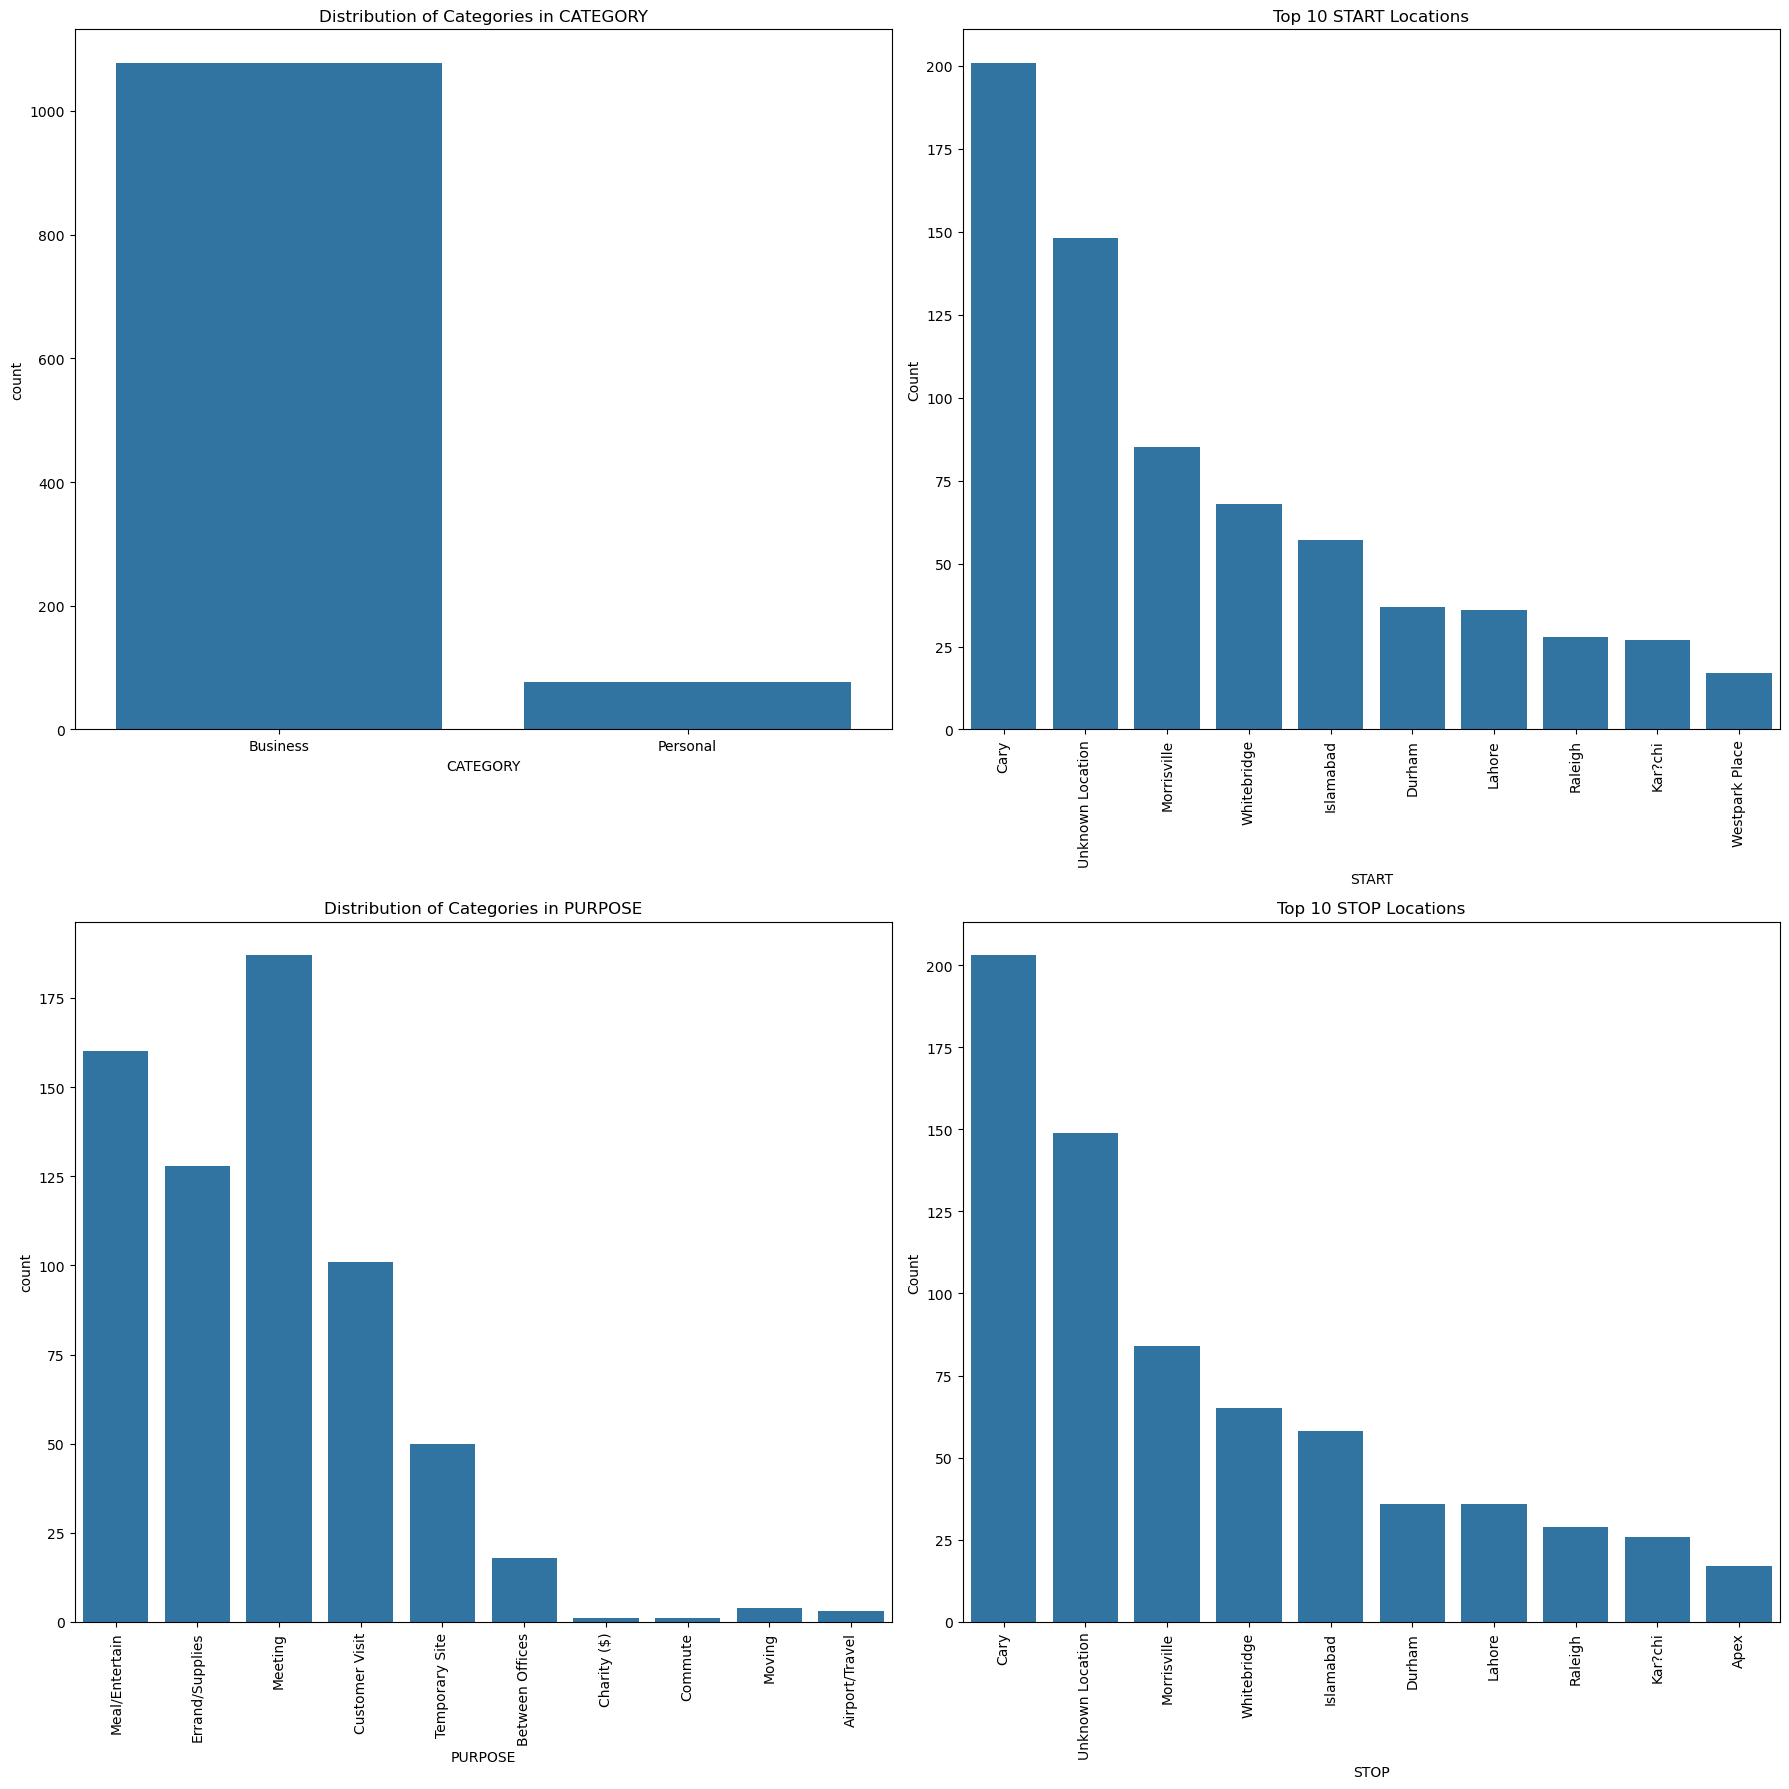

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already defined and processed

# Convert 'CATEGORY' column to categorical data type
df['CATEGORY'] = df['CATEGORY'].astype('category')

fig, axes = plt.subplots(2, 2, figsize=(18, 18))

# Distribution of Categories in CATEGORY
sns.countplot(data=df, x='CATEGORY', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Categories in CATEGORY')

# Distribution of Categories in PURPOSE
sns.countplot(data=df, x='PURPOSE', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Categories in PURPOSE')
axes[1, 0].tick_params(axis='x', rotation=90)

# Top 10 locations for START
temp_start = df['START'].value_counts().nlargest(10).reset_index()
temp_start.columns = ['START', 'Count']  # Rename the columns
sns.barplot(data=temp_start, x='START', y='Count', ax=axes[0, 1])
axes[0, 1].set_title('Top 10 START Locations')
axes[0, 1].tick_params(axis='x', rotation=90)

# Top 10 locations for STOP
temp_stop = df['STOP'].value_counts().nlargest(10).reset_index()
temp_stop.columns = ['STOP', 'Count']  # Rename the columns
sns.barplot(data=temp_stop, x='STOP', y='Count', ax=axes[1, 1])
axes[1, 1].set_title('Top 10 STOP Locations')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


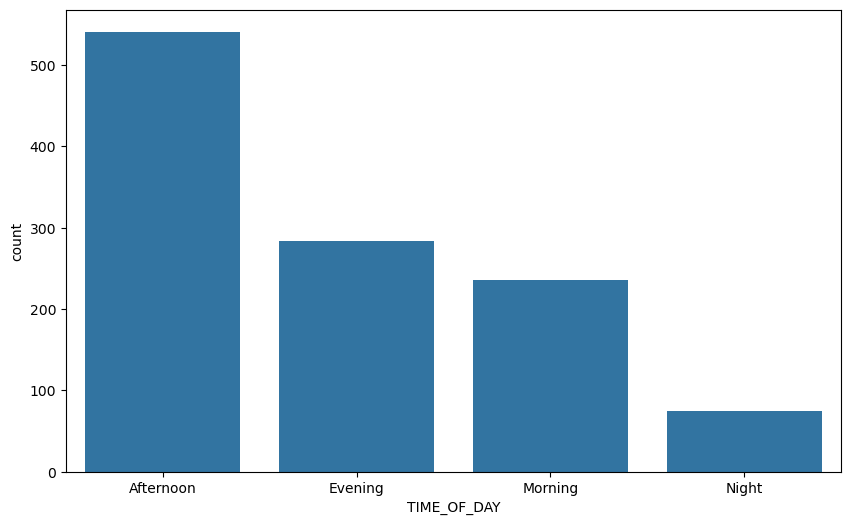

In [28]:
# Convert 'TIME_OF_DAY' column to categorical data type
df['TIME_OF_DAY'] = df['TIME_OF_DAY'].astype('category')

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='TIME_OF_DAY')
plt.show()

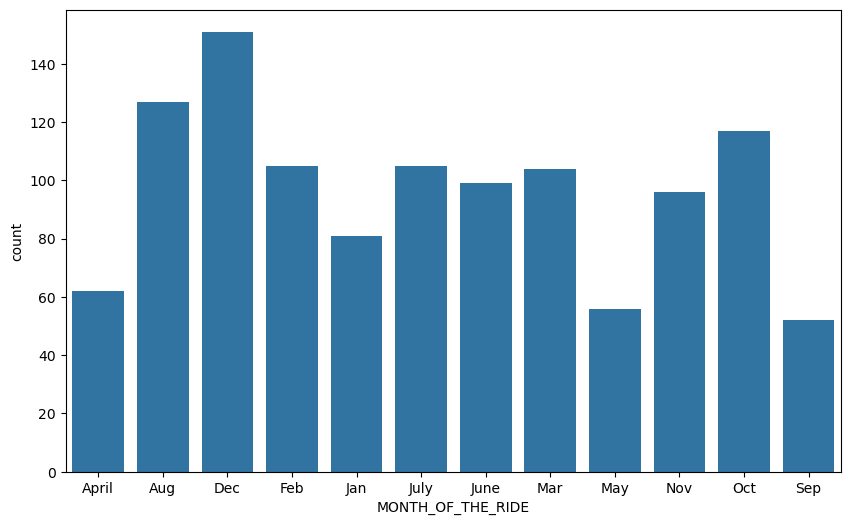

In [29]:
# Convert 'MONTH_OF_THE_RIDE' column to categorical data type
df['MONTH_OF_THE_RIDE'] = df['MONTH_OF_THE_RIDE'].astype('category')

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='MONTH_OF_THE_RIDE')
plt.show()

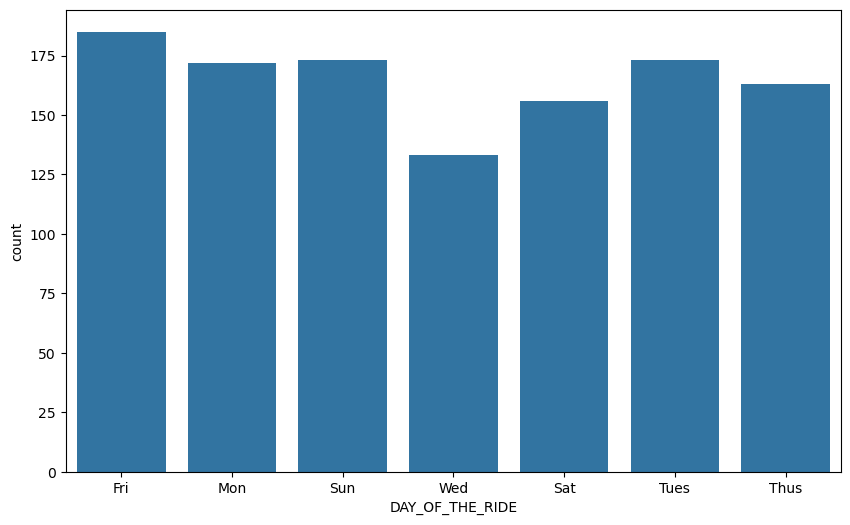

In [30]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DAY_OF_THE_RIDE')
plt.show()

/tmp/ipykernel_67532/879716397.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby('MONTH_OF_THE_RIDE')['TIME_DAY'].mean().reset_index()


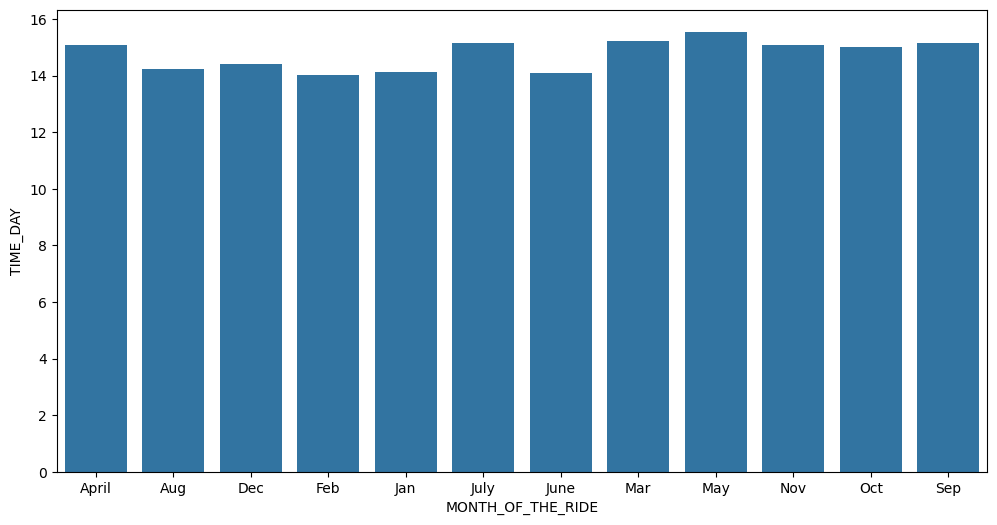

In [31]:
plt.figure(figsize=(12, 6))
temp = df.groupby('MONTH_OF_THE_RIDE')['TIME_DAY'].mean().reset_index()
sns.barplot(x='MONTH_OF_THE_RIDE', y='TIME_DAY', data=temp)
plt.show()